# Server

## Setting variables

In [1]:
rounds = 100
num_users = 10 # number of clients
target_test_acc = 0.99
lrs = [0.1]

C = 1
E = 5
B = 10 # 'all' for a single minibatch

In [2]:
import os

import socket
import struct
import pickle
import sys

from threading import Thread
from threading import Lock

import copy

import logging
import math
import random
import re
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from datetime import timedelta
from keras import backend as K
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tqdm import tqdm
tf.get_logger().setLevel(logging.ERROR)

2023-05-14 15:37:26.402299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 15:37:27.379485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Device

In [3]:
# if tf.test.gpu_device_name():
#     device = "gpu"
# else:
#     device = "cpu"

# print(device)

## Model

A CNN with two 5x5 convolution layers (the first with 32 channels, the second with 64, each followed with 2x2 max pooling), a fully connected layer with 512 units and ReLu activation, and a final softmax output layer (1,663,370 total parameters)

In [4]:
class CNN:
    @staticmethod
    def build(input_shape):
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(filters=64, padding='same', kernel_size=(5,5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(10, activation='softmax'))
        return model

initialize global model

In [5]:

# model = CNN()
# global_model = model.build((28,28,1))
# initial_weights = global_model.get_weights()

# restart the model from the folder
global_model = tf.keras.models.load_model('global_model.h5')
initial_weights = global_model.get_weights()

global_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 512)               1

2023-05-14 15:37:29.292336: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
# global_model.save('global_model.h5')

# Load data

In [7]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("x_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [9]:
train_batched = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(len(y_train)) # for testing on train set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

## variables

In [10]:
global global_weights    

clientsoclist = [0]*num_users

start_time = 0
weight_count = 0

global_weights = initial_weights
weights_list = {}

lock = Lock()

## Socket initialization
### Set host address and port number

### Required socket functions

In [11]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = pickle.dumps(msg)
    l_send = len(msg)
    msg = struct.pack('>I', l_send) + msg
    sock.sendall(msg)
    return l_send

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    msg =  recvall(sock, msglen)
    msg = pickle.loads(msg)
    return msg

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

In [12]:
def average_weights(weights_list):
    avg_weights = list()
    for j in range(len(global_weights)):
        weights = [weights_list[k][j] for k in range(num_users)]
        layer_mean = tf.math.reduce_mean(weights, axis=0)
        avg_weights.append(layer_mean)
        
    return avg_weights

## Receive users for aggregation

In [13]:
def receive(userid, r, num_users, conn): #thread for receive clients
    global weight_count
    global global_weights
    global weights_list
    
    msg = {
        'current_round': r,
        'rounds': rounds,
        'client_id': userid,
        'weight': global_weights
    }
    distribute = send_msg(conn, msg)    #send global weight
    receive = recv_msg(conn)    # get weights from clients
    with lock:
        weights_list[userid] = receive['weight']
        if receive['current_round'] == r:
            weight_count += 1
        
        if weight_count == num_users:
            global_weights = average_weights(weights_list)
            weight_count = 0

## Thread define

In [14]:
def run_thread(func, num_user, r):
    global clientsoclist
    global start_time
    
    thrs = []
    print("timer start!")
    start_time = time.time()    # store start time
    for i in range(num_user):
        conn, addr = s.accept()
        print('Conntected with', addr)
        # append client socket on list
        clientsoclist[i] = conn
        args = (i, r, num_user, conn)
        thread = Thread(target=func, args=args)
        thrs.append(thread)
        thread.start()
    for thread in thrs:
        thread.join()
    end_time = time.time()  # store end time
    print("TrainingTime: {} sec".format(end_time - start_time))

In [15]:
host_name = socket.gethostbyname(socket.gethostname())
# host_name = '172.31.2.147' 172.31.24.39
port_number = 12345
print(host_name)

172.31.20.147


In [16]:
print(host_name)

172.31.20.147


### Open the server socket

In [17]:
s = socket.socket()
s.bind((host_name, port_number))
s.listen(10)

## Comunication overhead

In [18]:
loss='categorical_crossentropy'
metrics = ['accuracy']
cce = tf.keras.losses.CategoricalCrossentropy()
# result_per_lr = {}    
dir = ''
with open(dir+'result_per_lr_10_1_5_0.1.pickle', 'rb') as handle:
    result_per_lr = pickle.load(handle)
start = time.time()


    
for lr in lrs:
    train_losses = result_per_lr[lr]['train_losses']
    train_accs = result_per_lr[lr]['train_accs']
    test_losses = result_per_lr[lr]['test_losses']
    test_accs = result_per_lr[lr]['test_accs']
    
#     train_losses = []
#     train_accs = []
#     test_losses = []
#     test_accs = []
    
    print('\nlearning rate: {}'.format(lr))
    
    saved_round = 99
    for r in range(saved_round,rounds):
#     for r in range(rounds):
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        run_thread(receive, num_users, r)
    
        # evaluate current round
        start = time.time()
        global_model.set_weights(global_weights)
        
        # test global model on full training set
        for (X,y) in train_batched:
            preds = global_model.predict(X)
            train_loss = cce(y, preds)
            train_acc = accuracy_score(tf.argmax(preds, axis=1), tf.argmax(y, axis=1))
            train_losses.append(train_loss.numpy())
            train_accs.append(train_acc)

        # test global model on testing set
        for(X, y) in test_batched:
            preds = global_model.predict(X)
            test_loss = cce(y, preds)
            test_acc = accuracy_score(tf.argmax(preds, axis=1), tf.argmax(y, axis=1))
            test_losses.append(test_loss.numpy())
            test_accs.append(test_acc)

        elapsed = (time.time() - start)

        print('comm_round: {}/{} | test_acc: {:.3%} | test_loss: {:.3} | train_acc: {:.3%} | train_loss: {:.3} | elapsed: {}'.format(r+1, rounds, test_acc, test_loss, train_acc, train_loss, timedelta(seconds=elapsed)))
        print('\n')
        global_model.save('global_model.h5')
        
        result_per_lr[lr] = {
            'train_accs' : train_accs,
            'test_accs' : test_accs,
            'train_losses' : train_losses,
            'test_losses' : test_losses
                              }
        with open(dir+'result_per_lr_{}_{}_{}_{}.pickle'.format(B,C,E, lr), 'wb') as handle:
            pickle.dump(result_per_lr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    


learning rate: 0.1
timer start!
Conntected with ('172.31.20.147', 57310)
Conntected with ('172.31.26.96', 56584)
Conntected with ('172.31.26.96', 33744)
Conntected with ('172.31.26.96', 33750)
Conntected with ('172.31.26.38', 47590)
Conntected with ('172.31.26.38', 47600)
Conntected with ('172.31.26.38', 47606)
Conntected with ('172.31.23.109', 60994)
Conntected with ('172.31.23.109', 32778)
Conntected with ('172.31.23.109', 32784)
TrainingTime: 204.767587184906 sec


2023-05-14 15:40:55.161375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [60000,10]
	 [[{{node Placeholder/_1}}]]


1875/1875 [==============================] - 9s 5ms/step


2023-05-14 15:41:05.560035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10000,10]
	 [[{{node Placeholder/_1}}]]


313/313 [==============================] - 2s 5ms/step
comm_round: 100/100 | test_acc: 98.780% | test_loss: 0.0422 | train_acc: 99.012% | train_loss: 0.028 | elapsed: 0:00:12.642601




In [19]:
with open(dir+'result_per_lr_{}_{}_{}_{}.pickle'.format(B,C,E, lr), 'wb') as handle:
    pickle.dump(result_per_lr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open(dir+'result_per_lr_10_1_5_0.1.pickle', 'rb') as handle:
    result_per_lr = pickle.load(handle)

In [51]:
max_acc = max(result_per_lr[0.1]['test_accs'])
print(max_acc)

0.9892


In [54]:
max_acc_rount = 0
def get_plotted_metrics(result_per_lr, c_rounds):
    plotted_train_accs= []
    plotted_test_accs = []
    plotted_train_losses = []
    plotted_test_losses = []
    max_acc_rount = 0
    for c in range(c_rounds):
        if result_per_lr[lr]['test_accs'][c] == max_acc:
            max_acc_rount = c
        plotted_train_accs.append(result_per_lr[0.1]['train_accs'][c])
        plotted_test_accs.append(result_per_lr[lr]['test_accs'][c])
        plotted_train_losses.append(result_per_lr[lr]['train_losses'][c])
        plotted_test_losses.append(result_per_lr[lr]['test_losses'][c])
            
#         best_train_acc = 0
#         best_test_acc = 0
#         best_train_loss = math.inf
#         best_test_loss = math.inf
#         for lr in result_per_lr.keys():
#             best_train_acc = max(best_train_acc, result_per_lr[lr]['train_accs'][c])
#             best_test_acc = max(best_test_acc, result_per_lr[lr]['test_accs'][c])
#             best_train_loss = min(best_train_loss, result_per_lr[lr]['train_losses'][c])
#             best_test_loss = min(best_test_loss, result_per_lr[lr]['test_losses'][c])

#         if c == 0:
#             plotted_train_accs.append(best_train_acc)
#             plotted_test_accs.append(best_test_acc)
#             plotted_train_losses.append(best_train_loss)
#             plotted_test_losses.append(best_test_loss)
#         else:
#             if plotted_train_accs[-1] > best_train_acc:
#                 plotted_train_accs.append(plotted_train_accs[-1])
#             else:
#                 plotted_train_accs.append(best_train_acc)

#             if plotted_test_accs[-1] > best_test_acc:
#                 plotted_test_accs.append(plotted_test_accs[-1])
#             else:
#                 plotted_test_accs.append(best_test_acc)

#             if plotted_train_losses[-1] < best_train_loss:
#                 plotted_train_losses.append(plotted_train_losses[-1])
#             else:
#                 plotted_train_losses.append(best_train_loss)

#             if plotted_test_losses[-1] < best_test_loss:
#                 plotted_test_losses.append(plotted_test_losses[-1])
#             else:
#                 plotted_test_losses.append(best_test_loss)

    return plotted_train_accs, plotted_test_accs, plotted_train_losses, plotted_test_losses, max_acc_rount

In [55]:
plotted_train_accs, plotted_test_accs, plotted_train_losses, plotted_test_losses, max_acc_rount = get_plotted_metrics(result_per_lr, rounds)

In [57]:
print(max_acc_rount)
print(result_per_lr[0.1]['test_accs'][max_acc_rount])
print(max_acc)

93
0.9892
0.9892


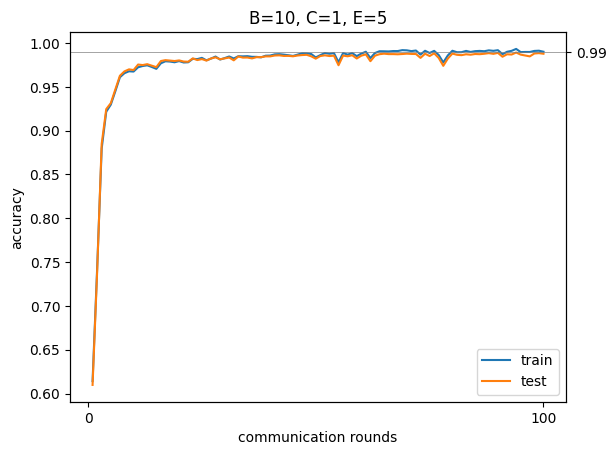

In [58]:
fig, ax = plt.subplots()
ax.plot(range(1, len(plotted_train_accs)+1), plotted_train_accs, label='train')
ax.plot(range(1,len(plotted_test_accs)+1), plotted_test_accs, label='test')
ax.set_xticks(np.arange(0, len(plotted_test_accs)+1, 100))
ax.axhline(y=target_test_acc, color='grey', linestyle='-', linewidth=0.5)
ax.set_ylabel('accuracy')

ax.set_xlabel('communication rounds')
ax.set_title('B={}, C={}, E={}'.format(B, C, E))
ax.legend()

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks([target_test_acc])

plt.show()

In [43]:
n_round_at_target = None
for i,acc in enumerate(plotted_test_accs):
    if acc>=target_test_acc:
        print("the number of rounds to achieve target test-accuracy: ")
        n_round_at_target = i+1
        print(n_round_at_target)
        break;

In [44]:
loss_at_target = None
for i,loss in enumerate(plotted_test_losses):
    if n_round_at_target and i==n_round_at_target-1:
        print("loss at target test-accuracy: ")
        loss_at_target = loss
        print(loss_at_target)
        break;

In [45]:
end_time = time.time()  # store end time
print("WorkingTime: {} sec".format(end_time - start_time))

WorkingTime: 752.738377571106 sec
